In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import PIL

import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

import matplotlib.pyplot as plt
%matplotlib inline

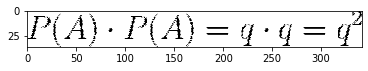

In [3]:
image_path = list(Path('/data/images-small/').rglob('*.png'))[100]
img = PIL.Image.open(image_path)
data = np.asarray(img)
plt.imshow(data, cmap='Greys')

In [4]:
image_dirname = Path('/data/images-small/')
data_generator = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.1,
)

In [5]:
dgen_args = {
    'directory': image_dirname,
    'target_size': (64, 128),
    'class_mode': 'sparse',
    'batch_size': 512,
    'shuffle': True,
    'color_mode': 'grayscale'
}

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

n_batches = len(train_dg)
trainX = []
for i in range(500):
    batch = train_dg.next()
    trainX.append(batch[0])
trainX = np.concatenate(trainX, axis=0)
data_generator.fit(trainX)

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

Found 22683 images belonging to 3 classes.
Found 2520 images belonging to 3 classes.


/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/koosterb/miniconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 22683 images belonging to 3 classes.
Found 2520 images belonging to 3 classes.


batch mean: -0.0140
batch std: 1.0115
batch shape: (512, 64, 128, 1)
Standard Normal: True


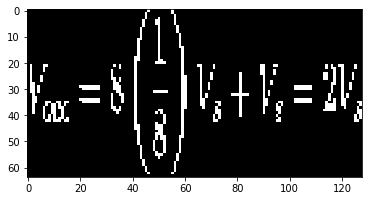

In [6]:
batch = train_dg.next()
X = batch[0]
print(f'batch mean: {X.mean():0.4f}')
print(f'batch std: {X.std():0.4f}')
print(f'batch shape: {X.shape}')
m, s = X.mean(), X.std()
print(f'Standard Normal: {(np.isclose(m,0, atol=0.1)) and (np.isclose(s, 1, atol=0.1))}')
plt.imshow(X[0, ..., 0], cmap='Greys')
plt.show()

In [7]:
def cv_model():
    input_shape = (64, 128, 1)
    input = layers.Input(shape=input_shape)
    tmp = input
    for i in range(5):
        #conv = layers.Conv2D(64*(2**i), 3, activation='relu', kernel_initializer='he_uniform', padding='same')(tmp)
        conv = layers.Conv2D(64*(2**i), 3, padding='same')(tmp)
        norm = layers.BatchNormalization()(conv)
        activ = layers.Activation('relu')(norm)
        pool = layers.MaxPooling2D(3, padding='same')(activ)
        tmp = pool
    flat = layers.Flatten()(tmp)
    for i in range(3):
        #flat = layers.Dense(256//(2**i), activation='relu', kernel_initializer='he_uniform')(flat)
        flat = layers.Dense(256//(2**i))(flat)
        norm = layers.BatchNormalization()(flat)
        activ = layers.Activation('relu')(norm)
        flat = activ
    output = layers.Dense(3, activation='softmax')(flat)
    model = models.Model(input, output)
    return model

def compile_model(model):
    opt = optimizers.Adam(0.01)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['sparse_categorical_accuracy']
    )
    return model

In [8]:
model = cv_model()
model = compile_model(model)
model.summary()

W0817 01:01:46.446888 140594044704512 deprecation.py:506] From /home/koosterb/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 128, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 43, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 43, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 43, 128)       512   

In [9]:
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    #plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    #plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

In [10]:
history1 = model.fit_generator(
    train_dg,
    steps_per_epoch=len(train_dg),
    validation_data=val_dg,
    validation_steps=len(val_dg),
    epochs=30,
    shuffle=True
)

Epoch 1/30


/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/koosterb/miniconda3/lib/python3.7/site

45/45 [==============================] - 35s 771ms/step - loss: 1.0551 - sparse_categorical_accuracy: 0.4709 - val_loss: 129.7138 - val_sparse_categorical_accuracy: 0.3968
Epoch 2/30
45/45 [==============================] - 26s 571ms/step - loss: 0.9949 - sparse_categorical_accuracy: 0.5224 - val_loss: 14.5056 - val_sparse_categorical_accuracy: 0.3968
Epoch 3/30
45/45 [==============================] - 26s 571ms/step - loss: 0.9664 - sparse_categorical_accuracy: 0.5434 - val_loss: 4.7008 - val_sparse_categorical_accuracy: 0.3968
Epoch 4/30
45/45 [==============================] - 26s 573ms/step - loss: 0.9380 - sparse_categorical_accuracy: 0.5602 - val_loss: 1.6278 - val_sparse_categorical_accuracy: 0.3968
Epoch 5/30
45/45 [==============================] - 26s 573ms/step - loss: 0.9143 - sparse_categorical_accuracy: 0.5738 - val_loss: 1.5173 - val_sparse_categorical_accuracy: 0.3968
Epoch 6/30
45/45 [==============================] - 26s 571ms/step - loss: 0.8789 - sparse_categorical_

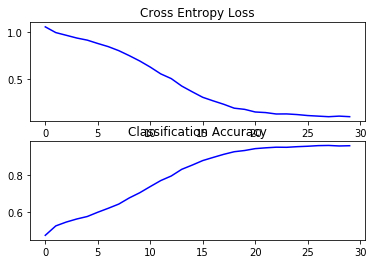

In [11]:
summarize_diagnostics(history1)

# analysis

In [64]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [49]:
import pandas as pd

correct_labels = []
predictions = []
conf = []
pics = []

for i in range(len(train_dg)):
    batch = train_dg[i]
    X = batch[0]
    yhat = model.predict(X)
    for pic in X:
        pics.append(pic)
    for pred in yhat.argmax(axis=1):
        predictions.append(pred)
    for elem in batch[1]:
        correct_labels.append(elem)
    for con in yhat.max(axis=1):
        conf.append(con)


test = pd.DataFrame()
test['predictions'] = np.asarray(predictions)
test['correct_label'] = np.asarray(correct_labels)
test['confidence'] = np.asarray(conf)

In [69]:
correct = []
for i, row in test.iterrows():
    correct.append(row.predictions == row.correct_label)

test['is_right'] = np.asarray(correct)
test.head()

,predictions,correct_label,confidence,is_right
0,2,1,0.924958,False
1,2,2,0.999994,True
2,2,0,0.999791,False
3,2,0,0.996885,False
4,2,2,0.999938,True


In [70]:
test.is_right.value_counts()

False    11487
True     11196
Name: is_right, dtype: int64

In [47]:
errors = test[test.is_right == False]
errors = errors.sort_values(by=['confidence'], ascending=False)
errors.head()

,predictions,correct_label,confidence,is_right
6050,2,0.0,1.0,False
10116,2,0.0,1.0,False
3219,2,0.0,1.0,False
19315,2,0.0,1.0,False
10281,2,0.0,1.0,False


In [71]:
test['correct_label'] = test['correct_label'].astype(int)
test.head()

,predictions,correct_label,confidence,is_right
0,2,1,0.924958,False
1,2,2,0.999994,True
2,2,0,0.999791,False
3,2,0,0.996885,False
4,2,2,0.999938,True


In [54]:
label_map = train_dg.class_indices
label_map

{'bio': 0, 'chem': 1, 'physics': 2}

In [66]:
classes = np.array(list(label_map.values()))

[0 1 2]
Confusion matrix, without normalization
[[ 236   13 4434]
 [ 152 1961 6887]
 [   0    1 8999]]


<IPython.core.display.Javascript object>


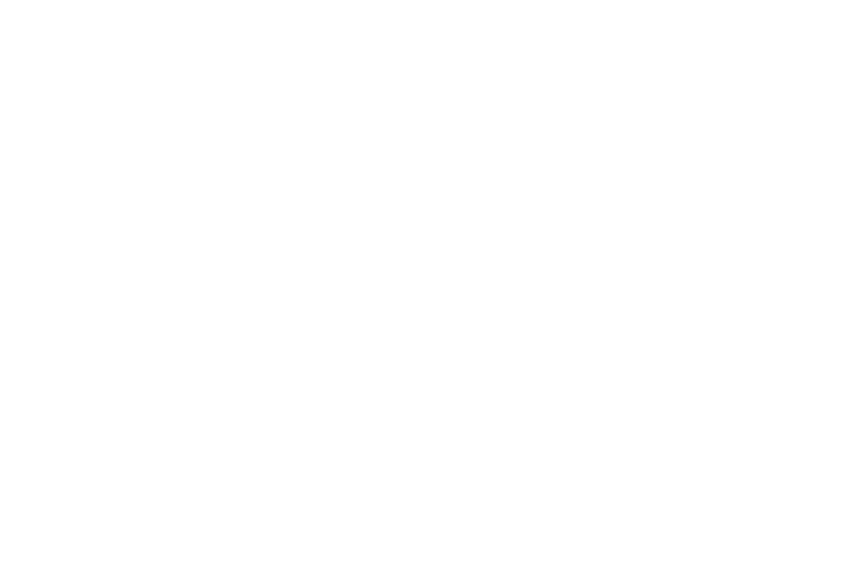

<IPython.core.display.Javascript object>


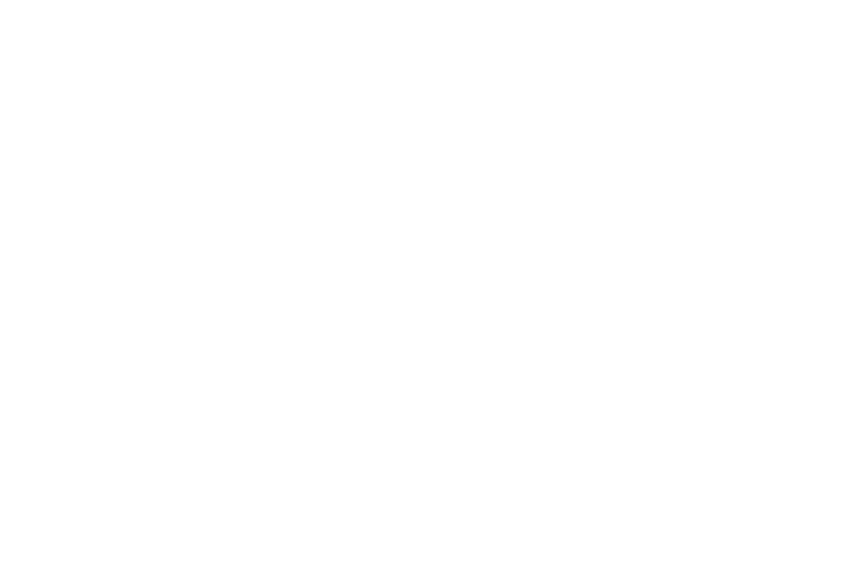

In [72]:
plot_confusion_matrix(test.correct_label, test.predictions, np.array(list(label_map.values())))